# Monthly Milk Production

Data overview 

Monthly milk production - pounds per cow from January 1962 to December 1975

## Reading file 

In [1]:
import os
os.chdir(r"C:\Users\Soham\Desktop\milk")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
os.getcwd()

'C:\\Users\\Soham\\Desktop\\milk'

In [2]:
milk = pd.read_csv('milk_data_set.csv',index_col='Month')

Check out the head of data frame

In [3]:
milk.head()

,Monthly milk production (pounds per cow)
Month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


 Make a index of time series

In [4]:
milk.index = pd.to_datetime(milk.index)

## Plot out the time series data

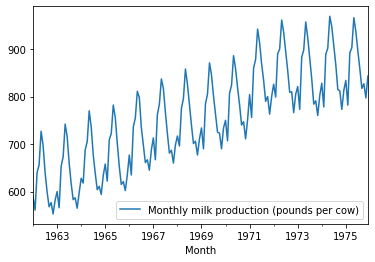

In [5]:
milk.plot()

## Train-Test split

Create a train test split using indexing (hint - .head() , .tail() , .iloc[])

Here , basically we want to specify that the test set is the last 12 months of data , with everything before it is the training 

In [6]:
milk.info()
train_set = milk.head(156)
test_set = milk.tail(12)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Monthly milk production (pounds per cow)    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


## Scale the data

Use sklearn.preprocessing to scale data using MinMaxScaler. Remember to only fit_transform on the training data , then transform the test data

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.fit_transform(test_set)

## Batch function

We will need a function that can feed batches of the training data

In [8]:
def next_batch(training_data,batch_size,steps):
    rand_start = np.random.randint(0,len(training_data)-steps)
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

## Setting up RNN model

In [9]:
import tensorflow as tf

## The constants

Define a constant in a single cell . Here , in parenthesiS of each constant , there are some values which are for solution . you can change it.

num_inputs(1)

num_time_steps (12)

num_neurons (200)

num_outputs (1)

learning_rate (0.05)

num_train_iterations (3000)

batch_size (1)

In [10]:
num_inputs = 1
num_time_steps = 12
num_neurons = 200
num_outputs = 1
learning_rate = 0.05
num_train_iterations = 3000
batch_size = 1

## Create placeholders for X and y

The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None,num_time_steps-1,num_outputs] . The reason we use num_time_steps-1 is because each of this will be one step shorter than original time series size , because we are training the RNN network to predict one point into the future based on the input sequence

In [11]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

## Create RNN layer

In [12]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(
    num_units=num_neurons, activation =tf.nn.relu),output_size = num_outputs)

W0823 22:40:53.339267   652 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0823 22:40:53.350267   652 deprecation.py:323] From <ipython-input-12-a24cf5a927c9>:2: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Now pass in the cells varriable into  tf.nn.dynamic_rnn along with first placeholder X

In [13]:
outputs , states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32)

W0823 22:40:53.369268   652 deprecation.py:323] From <ipython-input-13-2a82ee6a6a5d>:1: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0823 22:40:54.393327   652 deprecation.py:506] From C:\Users\Soham\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0823 22:40:54.453330   652 deprecation.py:506] From C:\Users\Soham\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py:738: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with 

## Loss function and optimizer

Create mean squared error loss function, use it to minimize an Adam
Optimizer, remember to pass in learning rate

In [14]:
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)

Intialize the global variables and create an instance of tf.train.Saver()

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Session

Run Tensor flow session that trains on the batches created by next_batch
function and also add a loss evalution for every 100 training iterations

In [16]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [17]:
with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:

    sess.run(init)

    for iteration in range(num_train_iterations):
        
        X_batch , y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        if iteration %200 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print (iteration,"\tMSE",mse)
    saver.save(sess, "./ex_time_series_model_codealong")

0 	MSE 815551.3
200 	MSE 0.04282625
400 	MSE 0.012994054
600 	MSE 0.012510677
800 	MSE 0.01002481
1000 	MSE 0.011912115
1200 	MSE 0.011597359
1400 	MSE 0.011285614
1600 	MSE 0.0063058506
1800 	MSE 0.008136883
2000 	MSE 0.011449672
2200 	MSE 0.010401604
2400 	MSE 0.0113203535
2600 	MSE 0.006379453
2800 	MSE 0.009324121


## Testing data

In [18]:
test_set

,Monthly milk production (pounds per cow)
Month,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


## Generative session

Fill out the session code to generate 12 months of data based of the last 12 months of data from the training set

In [19]:
with tf.Session() as sess:
    saver.restore(sess, "./ex_time_series_model_codealong")
    train_seed = list(train_scaled[-12:])
    for iteration in range (12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict = {X:X_batch})
        train_seed.append(y_pred[0,-1,0])

W0823 22:54:11.663928   652 deprecation.py:323] From C:\Users\Soham\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [20]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.6140299,
 0.63771844,
 0.6513331,
 0.6539974,
 0.67377067,
 0.67894006,
 0.67737293,
 0.65902615,
 0.61867905,
 0.57778585,
 0.52162814,
 0.50044596]

Grab the portion of the results that are generated values and apply inverse_transform on them to turn them back into milk production value units lbs per cow and reshape results to be (12,1)

In [21]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

Create a new coloumn on test_set called "Generated" and set it equal to the generated results

In [22]:
test_set['Generated'] = results

C:\Users\Soham\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
test_set

,Monthly milk production (pounds per cow),Generated
Month,,
1975-01-01,834,894.981506
1975-02-01,782,899.340149
1975-03-01,892,901.845215
1975-04-01,903,902.335510
1975-05-01,966,905.973877
1975-06-01,937,906.924927
1975-07-01,896,906.636597
1975-08-01,858,903.260803
1975-09-01,817,895.836914


## Plot out training-testing result for comparison

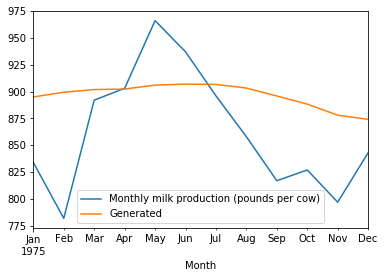

In [24]:
test_set.plot()